=== Coordinate ranges after conversion ===
Lat range: -89.63 to 89.63
Lon range: -179.65 to 180.00
Pixels in region: 2639

Daily accumulated precipitation:
  Min: -3274999992612054075660413435904.00 mm
  Max: 583.12 mm
  Mean: -16657511355652130511781888.00 mm
  Valid pixels in region: 2639
  Pixels with rain (>0.1mm): 1487
  Color scale: 0.00 to 128.20 mm


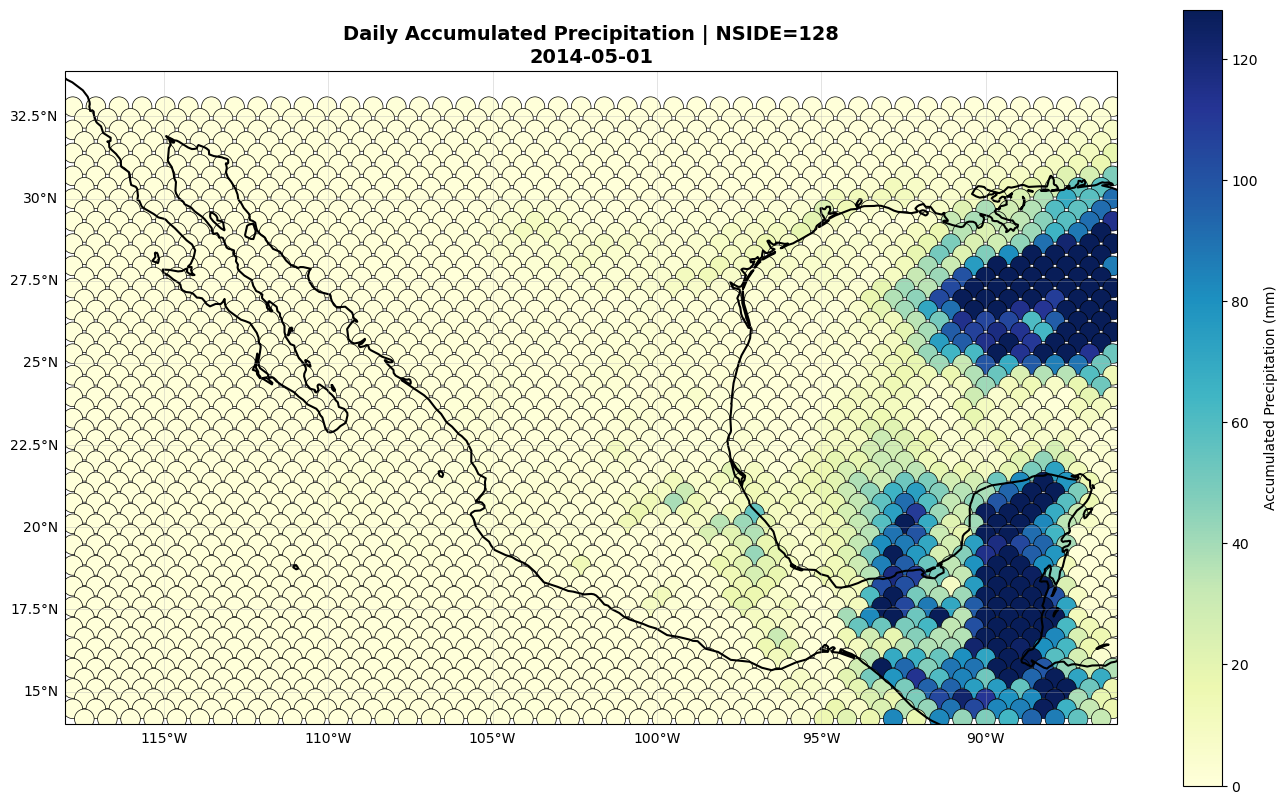

In [1]:
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import healpy as hp
import matplotlib.pyplot as plt

def plot_daily_accumulated_precipitation(store_path, nside_group):
    """
    Plot accumulated precipitation for the entire day
    """
    lat_min, lat_max = 14.0, 33.0  
    lon_min, lon_max = -118.0, -86.0
    
    ds_zarr = xr.open_zarr(store_path, consolidated=True)
    nside = int(nside_group.split('_')[1]) if '_' in nside_group else 8
    npix = hp.nside2npix(nside)
    
    # Get pixel coordinates
    pixels = np.arange(npix)
    theta, phi = hp.pix2ang(nside, pixels)
    lats = 90.0 - np.degrees(theta)
    lons = np.degrees(phi)  # This gives 0-360
    
    # CRITICAL FIX: Convert longitude from 0-360 to -180-180
    lons = np.where(lons > 180, lons - 360, lons)
    
    print(f"=== Coordinate ranges after conversion ===")
    print(f"Lat range: {lats.min():.2f} to {lats.max():.2f}")
    print(f"Lon range: {lons.min():.2f} to {lons.max():.2f}")
    
    # Filter to region (now should work!)
    mask = (
        (lats >= lat_min) & (lats <= lat_max) &
        (lons >= lon_min) & (lons <= lon_max)
    )
    
    print(f"Pixels in region: {np.sum(mask)}")
    
    # Calculate daily accumulation
    # IMERG is in mm/hr, multiply by 0.5 (30-min intervals) and sum
    daily_accum = (ds_zarr['precipitation'] * 0.5).sum(dim='time')
    
    print(f"\nDaily accumulated precipitation:")
    print(f"  Min: {np.nanmin(daily_accum.values):.2f} mm")
    print(f"  Max: {np.nanmax(daily_accum.values):.2f} mm")
    print(f"  Mean: {np.nanmean(daily_accum.values):.2f} mm")
    
    # Get data for region
    lats_region = lats[mask]
    lons_region = lons[mask]
    data_region = daily_accum.values[mask]
    
    # Remove UNSEEN and NaN values
    valid_mask = (data_region != hp.UNSEEN) & (~np.isnan(data_region))
    lats_plot = lats_region[valid_mask]
    lons_plot = lons_region[valid_mask]
    data_plot = data_region[valid_mask]
    
    print(f"  Valid pixels in region: {len(data_plot)}")
    print(f"  Pixels with rain (>0.1mm): {np.sum(data_plot > 0.1)}")
    
    if len(data_plot) > 0 and np.max(data_plot) > 0:
        vmin = 0
        vmax = np.percentile(data_plot[data_plot > 0], 95)
        print(f"  Color scale: {vmin:.2f} to {vmax:.2f} mm")
    else:
        vmin, vmax = 0, 10
        print("WARNING: No precipitation detected!")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot
    sc = ax.scatter(
        lons_plot, lats_plot, c=data_plot,
        cmap='YlGnBu', vmin=vmin, vmax=vmax,
        s=200, transform=ccrs.PlateCarree(),
        edgecolors='black', linewidth=0.5
    )
    
    ax.coastlines(linewidth=1.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    
    # Get date from first timestep
    date_str = np.datetime_as_string(ds_zarr.time.values[0], unit='D')
    ax.set_title(f'Daily Accumulated Precipitation | NSIDE={nside}\n{date_str}', 
                 fontsize=14, fontweight='bold')
    
    cbar = plt.colorbar(sc, ax=ax, label='Accumulated Precipitation (mm)', 
                       shrink=0.8, pad=0.05)
    
    plt.tight_layout()
    plt.show()

# Usage
plot_daily_accumulated_precipitation("ZARR/IMERG_PRECIP_nside128.zarr", "NSIDE_128")

In [9]:
import json
import urllib.request
from datetime import datetime, timedelta

In [10]:
def add_mexico_border_standard():
    try:
        url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries/MEX.geo.json"
        with urllib.request.urlopen(url) as response:
            data = json.load(response)
        
        geom = data['features'][0]['geometry']
        coords_list = [geom['coordinates']] if geom['type'] == 'Polygon' else geom['coordinates']
        
        for poly in coords_list:
            ring = np.array(poly[0])
            plt.plot(ring[:, 0], ring[:, 1], 'k-', linewidth=1.5, alpha=1.0, zorder=10)
    except Exception as e:
        print(f"Could not load coastline: {e}")

In [34]:
def plot_precip_scatter(store_path, target_date, nside_val=128):
    #nside_group = f"nside_val_{nside_val}"
    ds_zarr = xr.open_zarr(store_path, consolidated=True)
    
    try:
        sample = ds_zarr.sel(time=target_date, method='nearest')
    except KeyError:
        print("Date not found, using first index.")
        sample = ds_zarr.isel(time=0)

    # get Data
    precip_mm = sample['precipitation'].values * 1000
    precip_mm = np.nan_to_num(precip_mm, nan=0.0)
    print(f"Max Precip Value: {precip_mm.max():.2f} mm") 
    # coordinate calculation
    npix = len(precip_mm)
    theta, phi = hp.pix2ang(nside_val, np.arange(npix))
    lats = 90.0 - np.degrees(theta)
    lons = np.degrees(phi)
    lons = (lons + 180) % 360 - 180 # Force -180 to 180

    # Mexico region and min precip Box: [-118, -86, 14, 33]
    mask = (lons >= -120) & (lons <= -85) & (lats >= 12) & (lats <= 35) & (precip_mm > 0.05)
    
    plot_lons = lons[mask]
    plot_lats = lats[mask]
    plot_data = precip_mm[mask]

    # plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sc = ax.scatter(plot_lons, plot_lats, c=plot_data, cmap="Blues", 
                    vmin=0, vmax=60, s=65, marker='o', edgecolors='none')
    add_mexico_border_standard()
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.2, shrink=0.9)
    cbar.set_label("Precipitation (mm)", fontsize=12)

    ax.set_title(f"Total Precipitation | {target_date} | NSIDE {nside_val}", fontsize=14)
    ax.set_xlim([-118, -86])
    ax.set_ylim([14, 33])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.show()

In [35]:
START = datetime(2014, 5, 1)
END = datetime(2014, 5, 2)

current_date = START
while current_date <= END:
    target_str = current_date.strftime("%Y-%m-%d")
    plot_precip_scatter("ZARR/IMERG_PRECIP_nside128.zarr", target_date=target_str, nside_val=128)
    current_date += timedelta(days=1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [26]:
ds_zarr = xr.open_zarr("ZARR/IMERG_PRECIP_nside128.zarr", consolidated=True)

In [27]:
ds_zarr

<xarray.Dataset> Size: 3GB
Dimensions:                         (time: 384, healpix_pixel: 196608)
Coordinates:
  * time                            (time) datetime64[ns] 3kB 2014-05-01T00:3...
  * healpix_pixel                   (healpix_pixel) int64 2MB 0 1 ... 196607
Data variables:
    MWprecipitation                 (time, healpix_pixel) float32 302MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    MWprecipSource                  (time, healpix_pixel) float32 302MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    randomError                     (time, healpix_pixel) float32 302MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    precipitationQualityIndex       (time, healpix_pixel) float32 302MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    precipitationUncal              (time, healpix_pixel) float32 302MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    MWobservationTime               (time, healpix_pixel) float32 302MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    precipitation                   (time, healpix_pixel) float32 302MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    IRprecipitation                 (time, healpix_pixel) float32 302MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    IRinfluence                     (time, healpix_pixel) float32 302MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, healpix_pixel) float32 302MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
Attributes: (12/16)
    nside_val:          128
    FileName:           3B-HHR.MS.MRG.3IMERG.20140502-S000000-E002959.0000.V0...
    MissingData:        
    DOI:                10.5067/GPM/IMERG/3B-HH/07
    DOIauthority:       http://dx.doi.org/
    AlgorithmID:        3IMERGHH
    ...                 ...
    ProcessingSystem:   PPS
    DataFormatVersion:  7e
    MetadataVersion:    7e
    ScanMode:           Grid
    history:            Created by ghiggi/gpm_api software on 2026-02-02 17:1...
    gpm_api_product:    IMERG-FR